In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow import nn

In [35]:
# Standardizing the size of all images 
mpl.rcParams['figure.figsize'] = (15,9)
mpl.rcParams['font.size'] = 15

In [36]:
df_train = pd.read_csv('DailyDelhiClimateTest.csv')
df_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [37]:
df_test = pd.read_csv('DailyDelhiClimateTest.csv')
df_test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [38]:
df = pd.concat((df_test, df_train), ignore_index=True)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['date'])

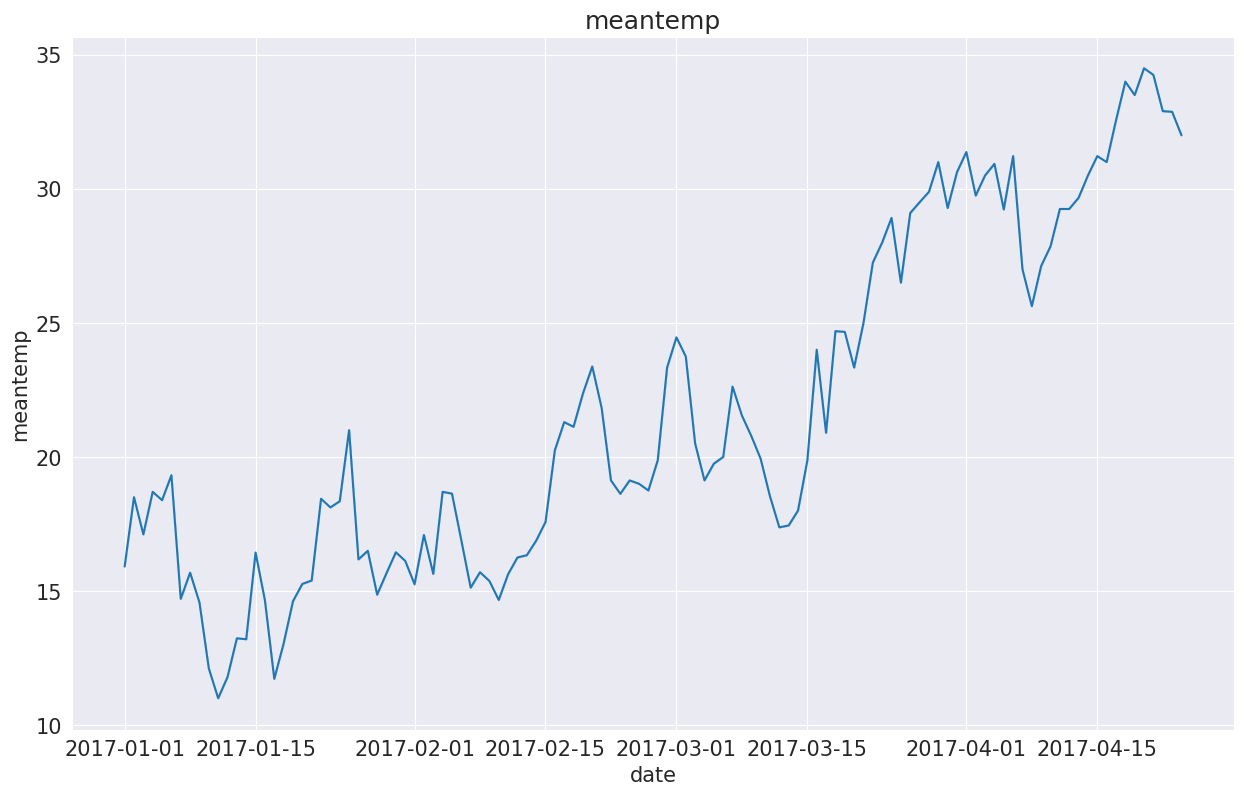

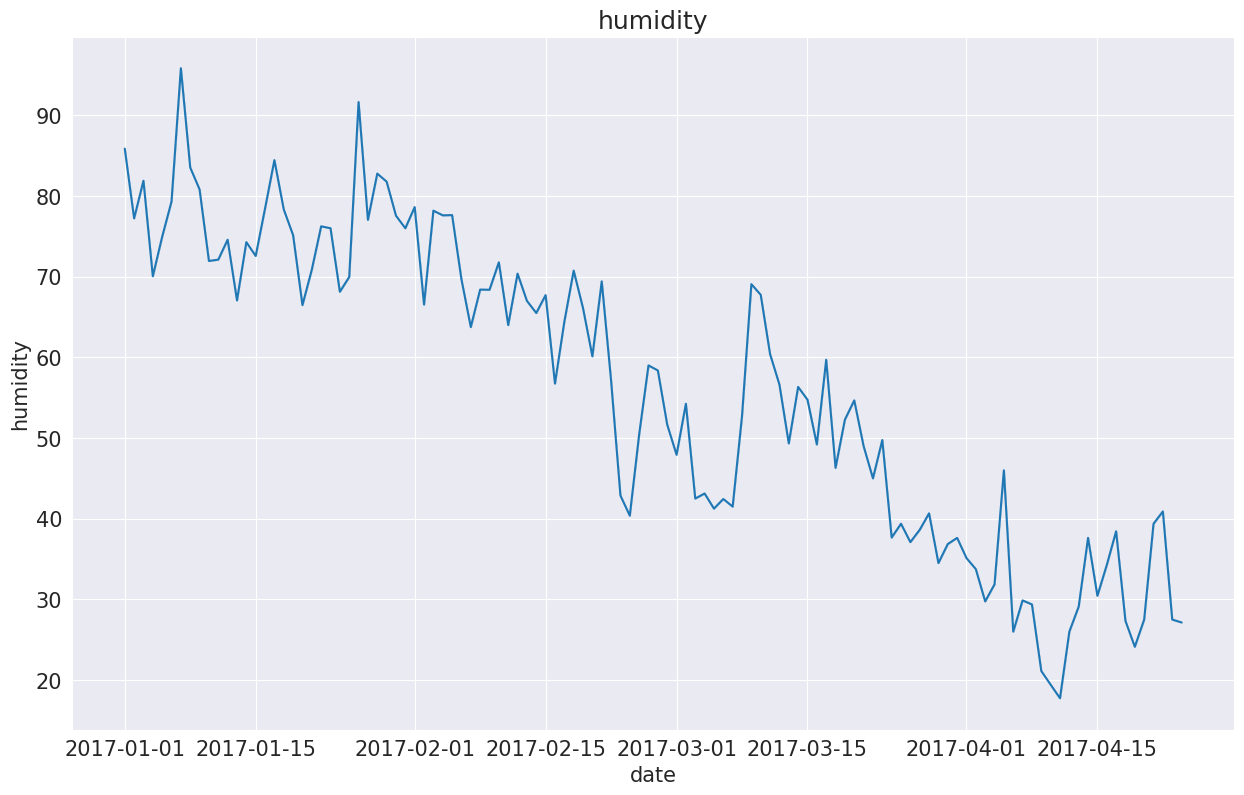

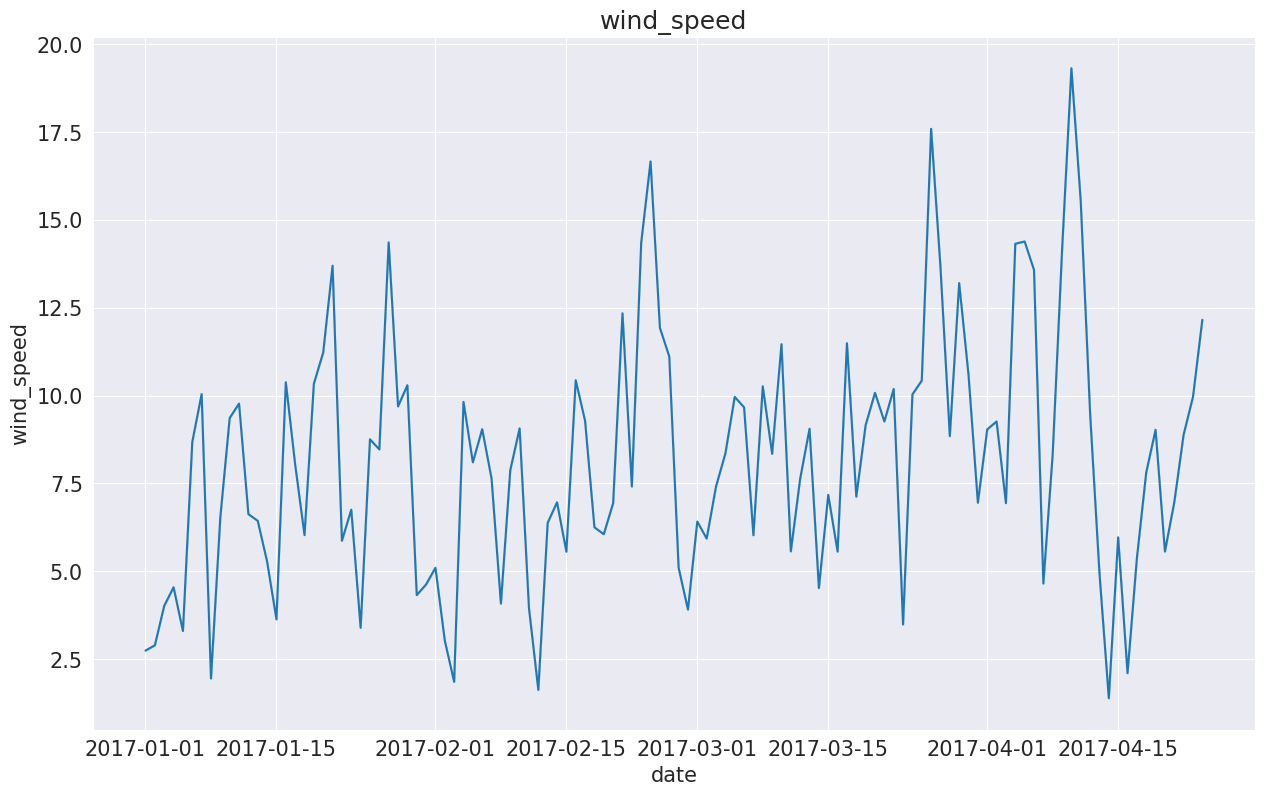

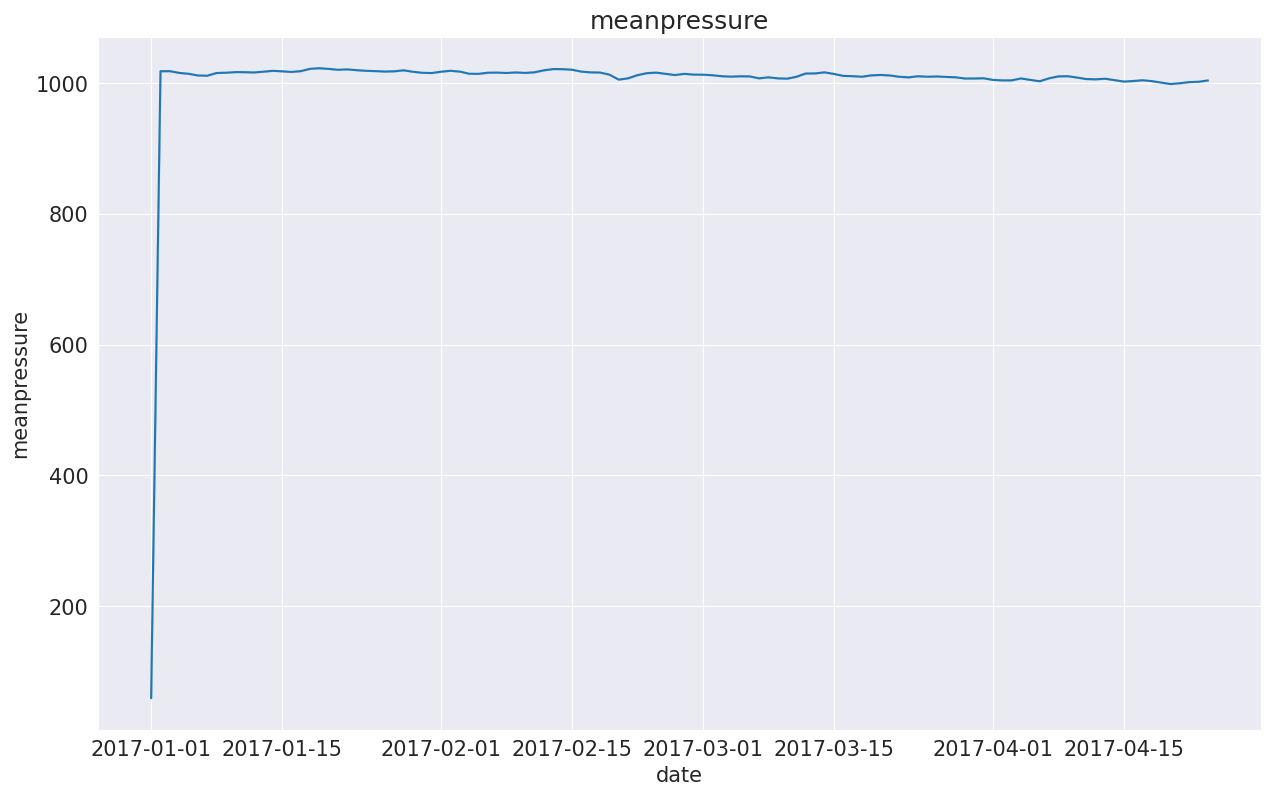

In [39]:
# Visualizing the behavior of all columns
columns = df.drop(columns=['date']).columns
for column in columns:
    sns.lineplot(x=df['date'], y=df[column])
    plt.title(column)
    plt.show()

In [40]:
# Function to convert our dataset in a time series dataset
def create_window(target, feature, window=1, offset=0):
    feature_new, target_new = [], []
    feature_np = feature.to_numpy()
    target_np = target.to_numpy()
    for i in range(window, target.shape[0] - offset):
        feature_list = feature_np[i - window:i]
        feature_new.append(feature_list.reshape(window, feature_np.shape[1]))
        target_new.append(target_np[i+offset].reshape(1))
    return np.array(feature_new), np.array(target_new)

In [41]:
# scale all the dataset (not including the date)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns='date'))
df_scaled = pd.DataFrame(df_scaled, columns=df.drop(columns='date').columns)

# Set the window to 10
window = 10
feature_columns = ['humidity', 'wind_speed', 'meanpressure', 'meantemp']

# Create a window with all the columns as features (excluding the date)
feature, target = create_window(df_scaled['meantemp'],df_scaled[feature_columns], window=window)
print(feature[0])
print(target[0])
print(df_scaled.head(12))

[[  1.55977599  -1.51176537 -10.60866965  -0.91597122]
 [  1.55977599  -1.51176537 -10.60866965  -0.91597122]
 [  1.10427549  -1.46950489   0.15988398  -0.50742583]
 [  1.10427549  -1.46950489   0.15988398  -0.50742583]
 [  1.35009308  -1.15535736   0.16050763  -0.72676626]
 [  1.35009308  -1.15535736   0.16050763  -0.72676626]
 [  0.72647727  -1.00745919   0.13094665  -0.47584081]
 [  0.72647727  -1.00745919   0.13094665  -0.47584081]
 [  0.98429309  -1.35597633   0.11560488  -0.52497307]
 [  0.98429309  -1.35597633   0.11560488  -0.52497307]]
[-0.37821438]
    meantemp  humidity  wind_speed  meanpressure
0  -0.915971  1.559776   -1.511765    -10.608670
1  -0.915971  1.559776   -1.511765    -10.608670
2  -0.507426  1.104275   -1.469505      0.159884
3  -0.507426  1.104275   -1.469505      0.159884
4  -0.726766  1.350093   -1.155357      0.160508
5  -0.726766  1.350093   -1.155357      0.160508
6  -0.475841  0.726477   -1.007459      0.130947
7  -0.475841  0.726477   -1.007459      0.1

In [42]:
# Function to create train and test datasets
def train_test(feature, target, perc_train = 0.9):
    size_train = int(len(feature) * perc_train)

    x_train = feature[0:size_train]
    y_train = target[0:size_train]

    x_test = feature[size_train: len(feature)]
    y_test = target[size_train: len(feature)]

    return x_train, x_test, y_train, y_test

<Axes: xlabel='date'>

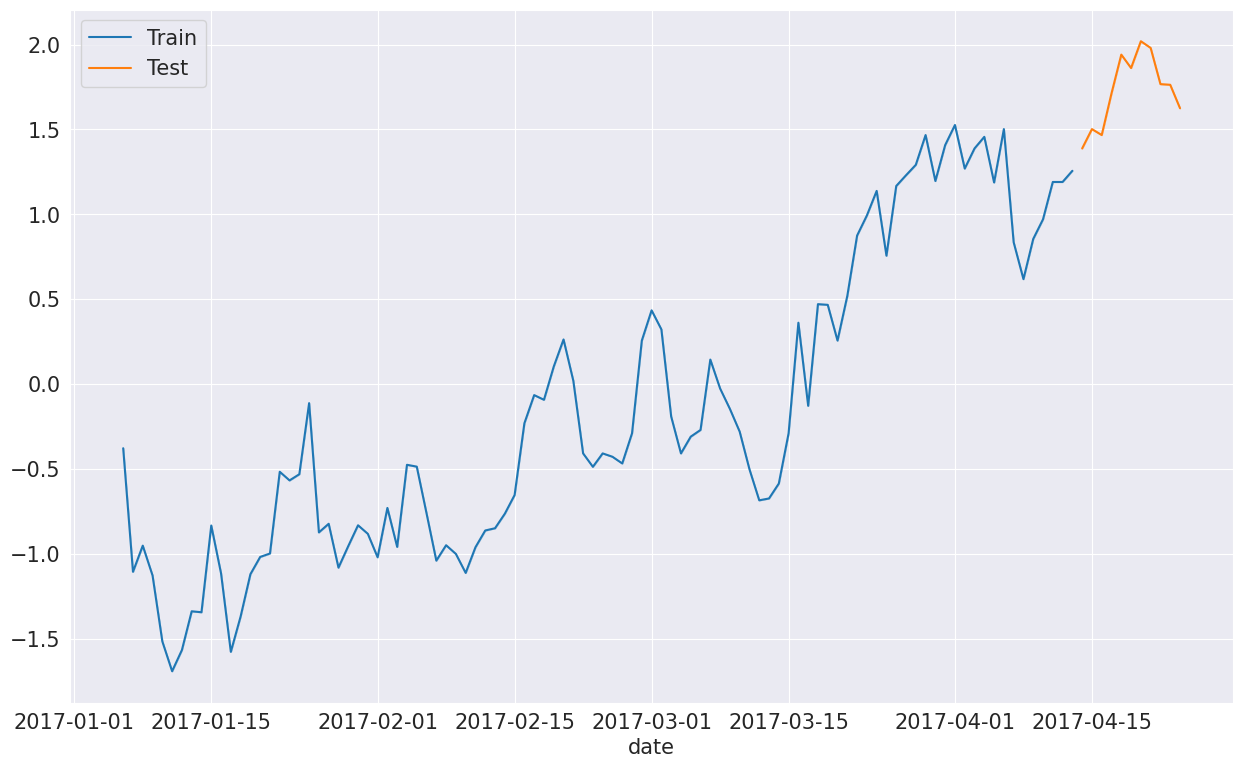

In [43]:
x_train, x_test, y_train, y_test = train_test(feature, target)

# Visualize the train and test data
sns.lineplot(x=df['date'].iloc[window:len(y_train) + window], y=y_train[:,0], label='Train')
sns.lineplot(x=df['date'].iloc[window + len(y_train):], y=y_test[:,0], label='Test')

In [44]:
# Create a standard model using LSTM
def model_lstm(x_shape):

    model = keras.Sequential()
    model.add(keras.layers.LSTM(64, input_shape=(x_shape[1], x_shape[2])))
    model.add(keras.layers.Dense(units=1))

    model.compile(loss='mean_squared_error', optimizer='RMSProp')
    return model

In [45]:
model = model_lstm(x_train.shape)
model.summary()

/home/eldar/GitHub/climate-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.0326 - val_loss: 2.5640
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2483 - val_loss: 1.6167
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1487 - val_loss: 0.9962
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1427 - val_loss: 0.7233
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1140 - val_loss: 0.6699
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1140 - val_loss: 0.6161
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1091 - val_loss: 0.4977
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0930 - val_loss: 0.4128
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0895 - val_loss: 0.3564
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0927 - val_loss: 0.4119
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1015 - val_loss: 0.3074
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0852 - val_loss: 0.5926
Epoch 13/50


In [47]:
# Function to create train and test datasets
def train_test(feature, target, perc_train = 0.9):
    size_train = int(len(feature) * perc_train)

    x_train = feature[0:size_train]
    y_train = target[0:size_train]

    x_test = feature[size_train: len(feature)]
    y_test = target[size_train: len(feature)]

    return x_train, x_test, y_train, y_test

<Axes: xlabel='date'>

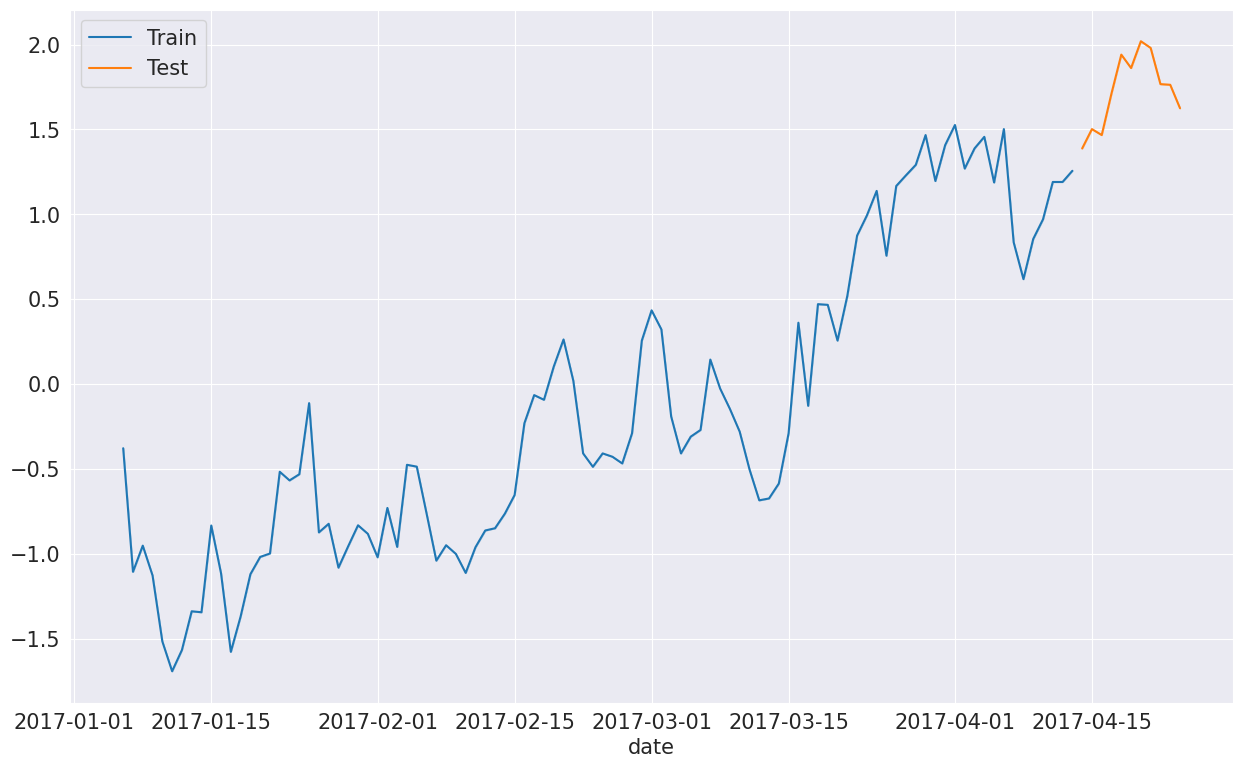

In [48]:
x_train, x_test, y_train, y_test = train_test(feature, target)

# Visualize the train and test data
sns.lineplot(x=df['date'].iloc[window:len(y_train) + window], y=y_train[:,0], label='Train')
sns.lineplot(x=df['date'].iloc[window + len(y_train):], y=y_test[:,0], label='Test')

In [50]:
model = model_lstm(x_train.shape)
model.summary()    

/home/eldar/GitHub/climate-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3476 - val_loss: 0.8986
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1300 - val_loss: 0.4603
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0960 - val_loss: 0.3261
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0939 - val_loss: 0.2504
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0865 - val_loss: 0.0844
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0877 - val_loss: 0.3774
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0931 - val_loss: 0.3374
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0763 - val_loss: 0.2009
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0748 - val_loss: 0.3159
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0726 - val_loss: 0.2325
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0662 - val_loss: 0.1812
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0698 - val_loss: 0.0790
Epoch 13/50


In [52]:
# Function to print the results of the fit process
def print_loss(result):
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.show()

# Function to print the y_predicted compared with the y_test
def print_test_x_prediction(y_test, y_predict, df_date, train_size, window=0):
    sns.lineplot(x=df_date.iloc[train_size + window:], y=y_test[:,0], label = 'Test')
    sns.lineplot(x=df_date.iloc[train_size + window:], y=y_predict[:,0], label = 'Predict')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


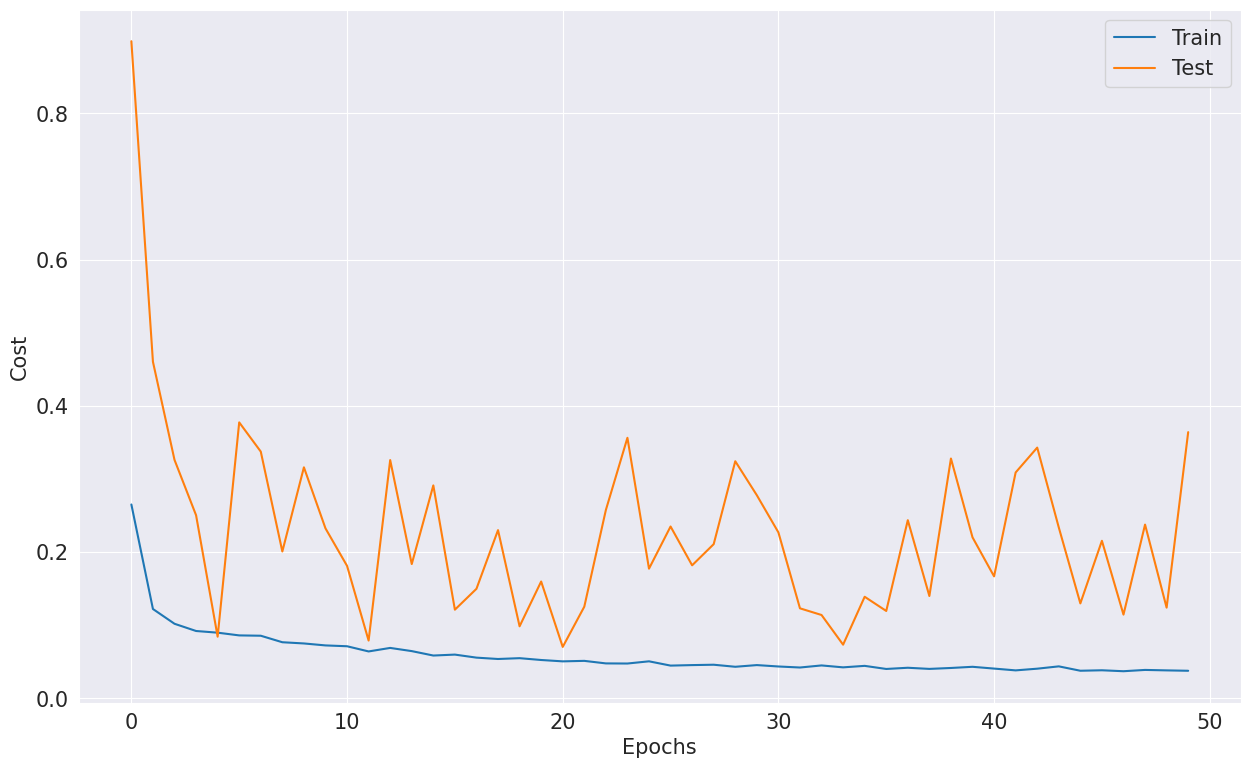

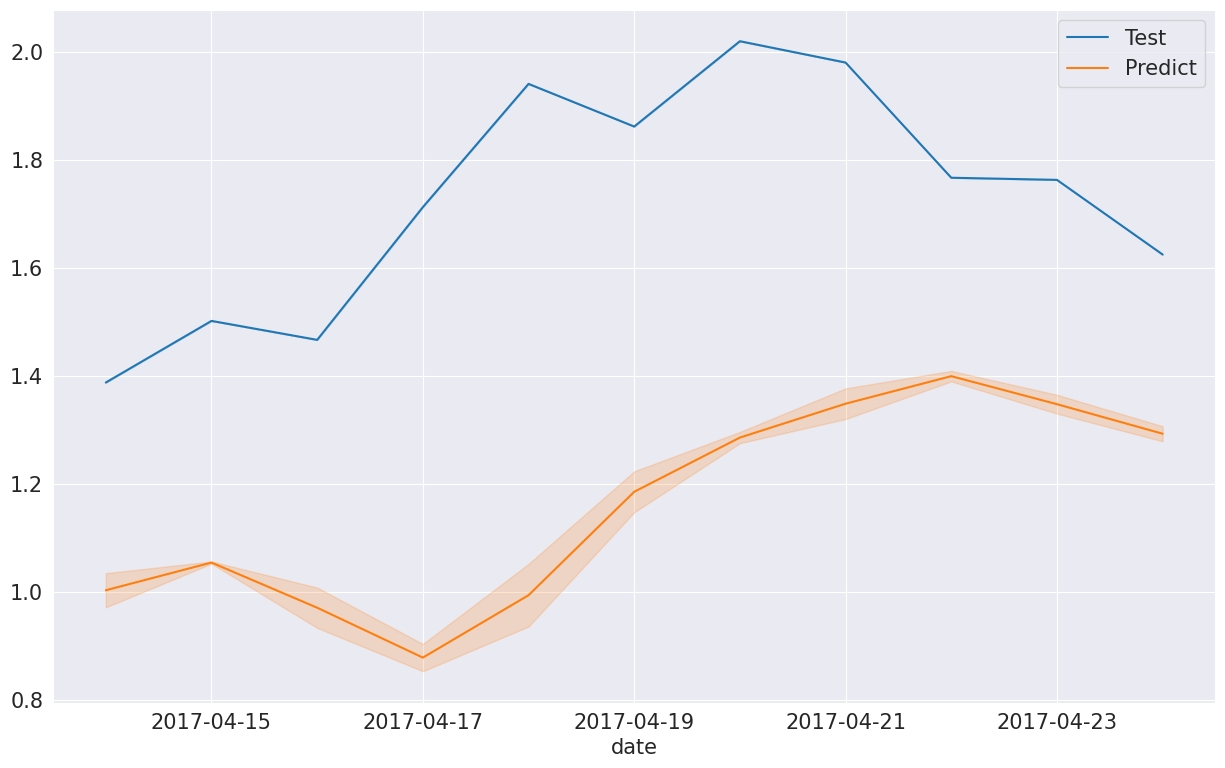

In [53]:
y_predict = model.predict(x_test)

print_loss(result)
print_test_x_prediction(y_test, y_predict, df['date'], len(y_train), window=window)

In [54]:
feature, target = create_window(df_scaled['meantemp'], df_scaled[['meantemp']], window=10)

x_train, x_test, y_train, y_test = train_test(feature, target)

model = model_lstm(x_train.shape)
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50)

Epoch 1/50


/home/eldar/GitHub/climate-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6600 - val_loss: 0.8524
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2028 - val_loss: 0.3331
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1370 - val_loss: 0.1097
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1169 - val_loss: 0.0516
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1284 - val_loss: 0.1873
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1266 - val_loss: 0.0279
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1019 - val_loss: 0.1297
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1114 - val_loss: 0.0404
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1047 - val_loss: 0.0592
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1035 - val_loss: 0.0970
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1009 - val_loss: 0.0684
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0821 - val_loss: 0.1154
Epoch 13/50
7/7 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


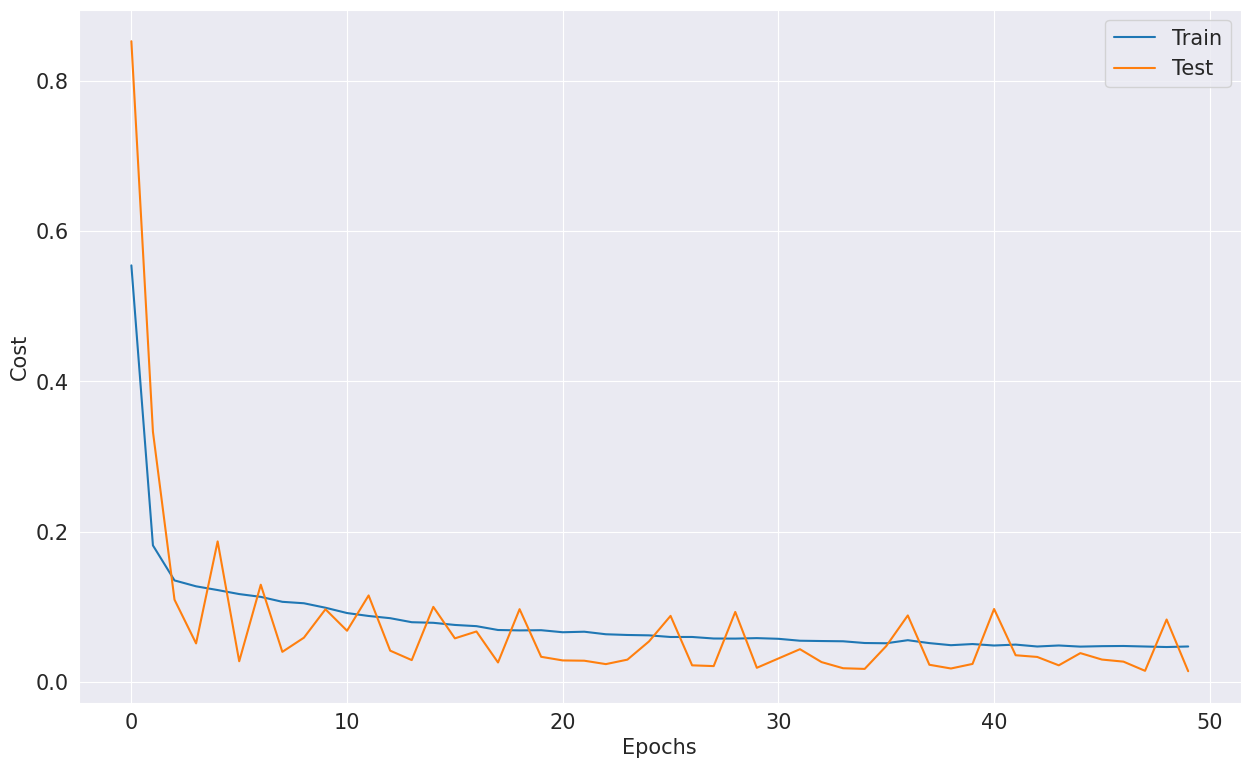

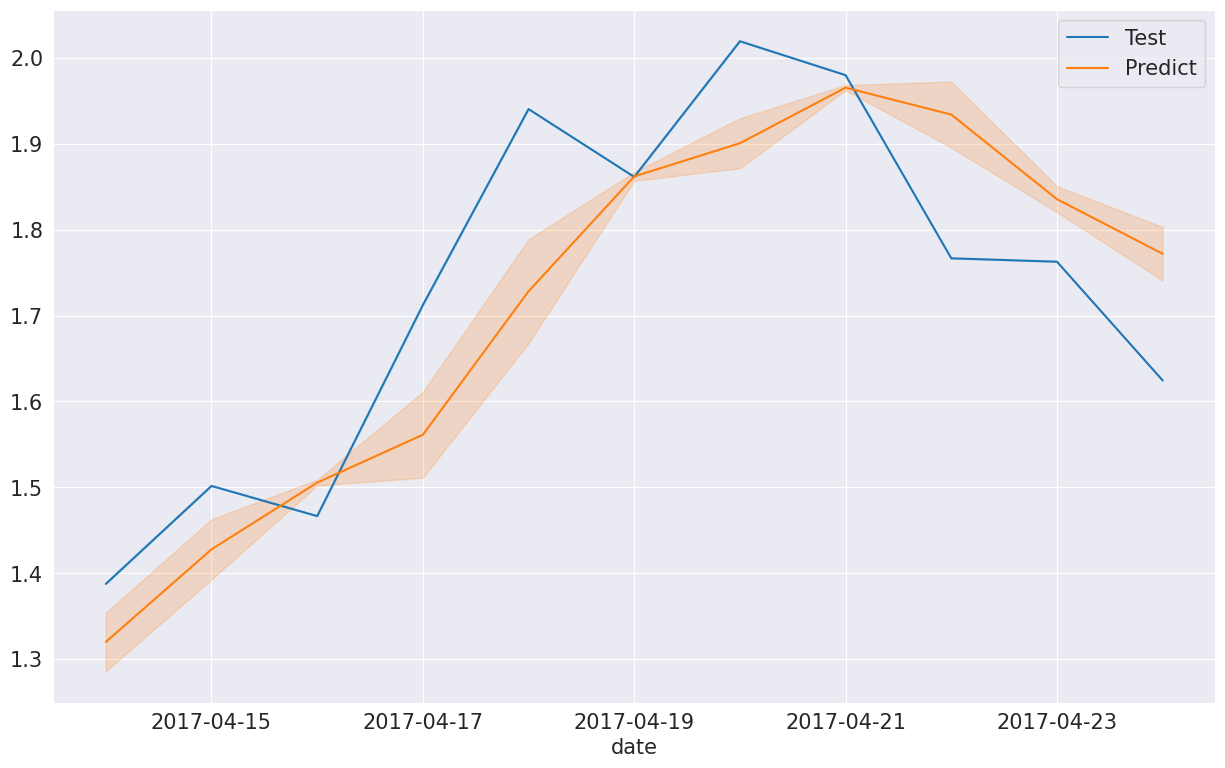

In [55]:
y_predict = model.predict(x_test)

print_loss(result)
print_test_x_prediction(y_test, y_predict, df['date'], len(y_train), window=window)

In [56]:
# Create a dense neural network
def model_dense(x_shape):
    model = keras.Sequential()
    model.add(keras.layers.Dense(64, input_dim=x_shape[1], activation=nn.relu))
    model.add(keras.layers.Dense(64,activation=nn.relu))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [57]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.day

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns=['date']))
df_scaled = pd.DataFrame(df_scaled, columns=df.drop(columns=['date']).columns)

feature_columns = ['humidity', 'wind_speed', 'meanpressure', 'month', 'year', 'day']

feature, target = df_scaled[feature_columns], df_scaled['meantemp']

feature, target = np.array(feature), np.array(target).reshape(-1,1)

x_train, x_test, y_train, y_test = train_test(feature, target)

model = model_dense(x_train.shape)
model.summary()

/home/eldar/GitHub/climate-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,673 (18.25 KB)

 Trainable params: 4,673 (18.25 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6904 - val_loss: 2.5098
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4654 - val_loss: 1.5539
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3056 - val_loss: 1.0305
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2425 - val_loss: 0.6780
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2094 - val_loss: 0.4892
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2209 - val_loss: 0.4262
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1916 - val_loss: 0.3893
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1674 - val_loss: 0.3787
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1823 - val_loss: 0.3433
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1614 - val_loss: 0.3234
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1396 - val_loss: 0.2784
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1508 - val_loss: 0.2364
Epoch 13/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


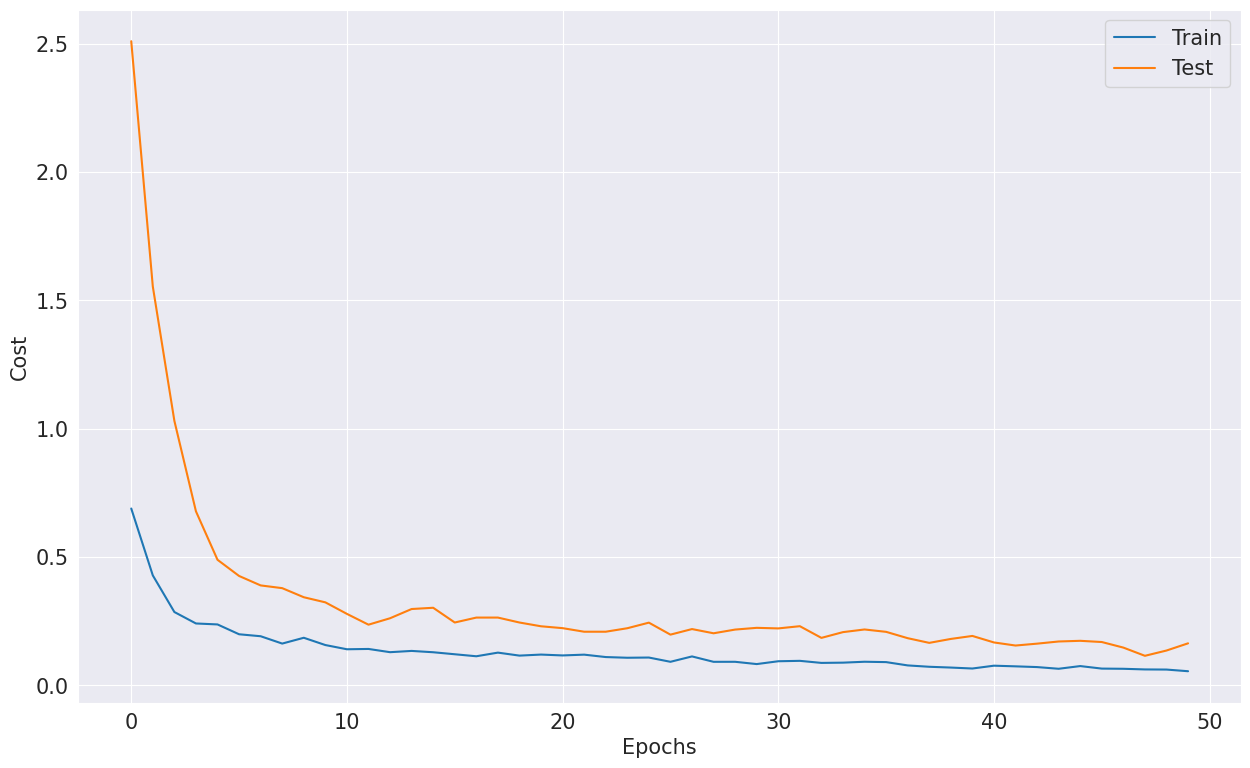

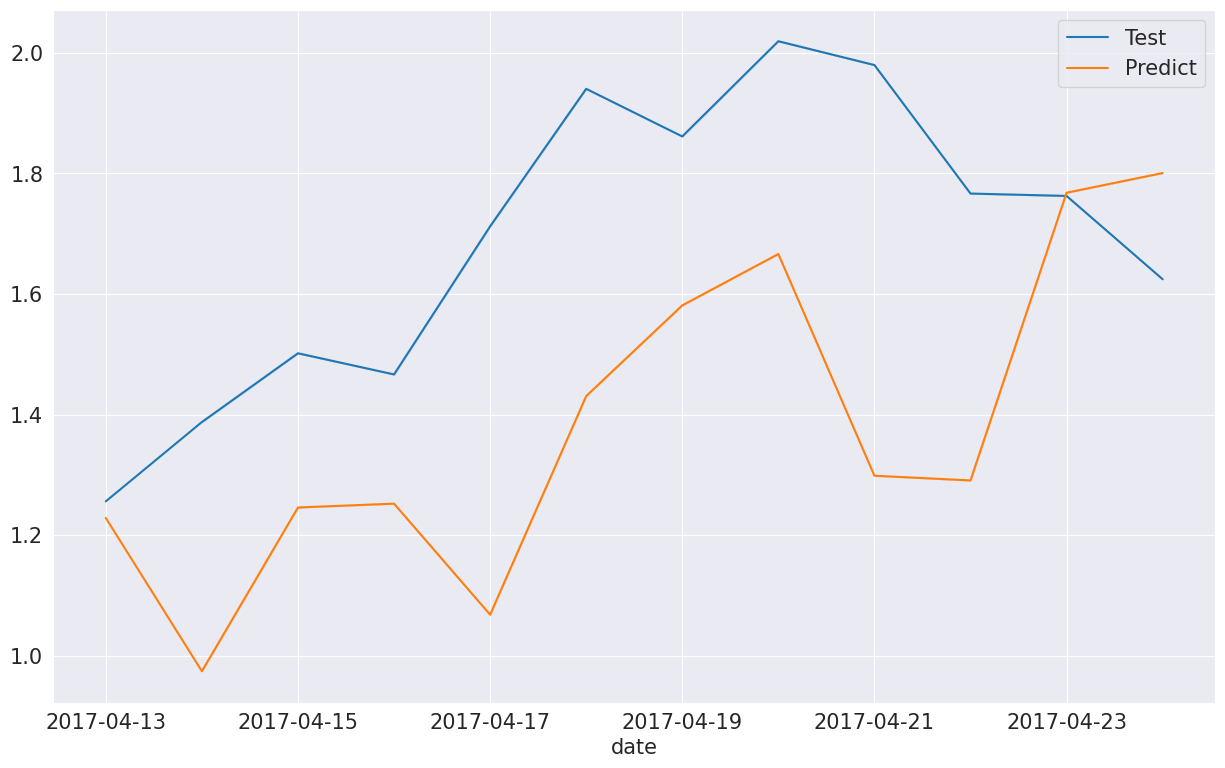

In [59]:
y_predict = model.predict(x_test)

print_loss(result)
print_test_x_prediction(y_test, y_predict, df['date'], len(y_train), window=0)

In [60]:
feature, target = create_window(df_scaled['meantemp'], df_scaled[['meantemp']], window=10)

feature = feature.reshape(-1, feature.shape[1] * feature.shape[2])
x_train, x_test, y_train, y_test = train_test(feature, target)

model = model_dense(x_train.shape)
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50)

Epoch 1/50


/home/eldar/GitHub/climate-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.2925 - val_loss: 0.4616
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2813 - val_loss: 0.0309
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1716 - val_loss: 0.1451
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2027 - val_loss: 0.1102
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1191 - val_loss: 0.0375
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1289 - val_loss: 0.0349
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1343 - val_loss: 0.0579
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1018 - val_loss: 0.0538
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0843 - val_loss: 0.0264
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0949 - val_loss: 0.0250
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1054 - val_loss: 0.0264
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0917 - val_loss: 0.0237
Epoch 13/50
7/7 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


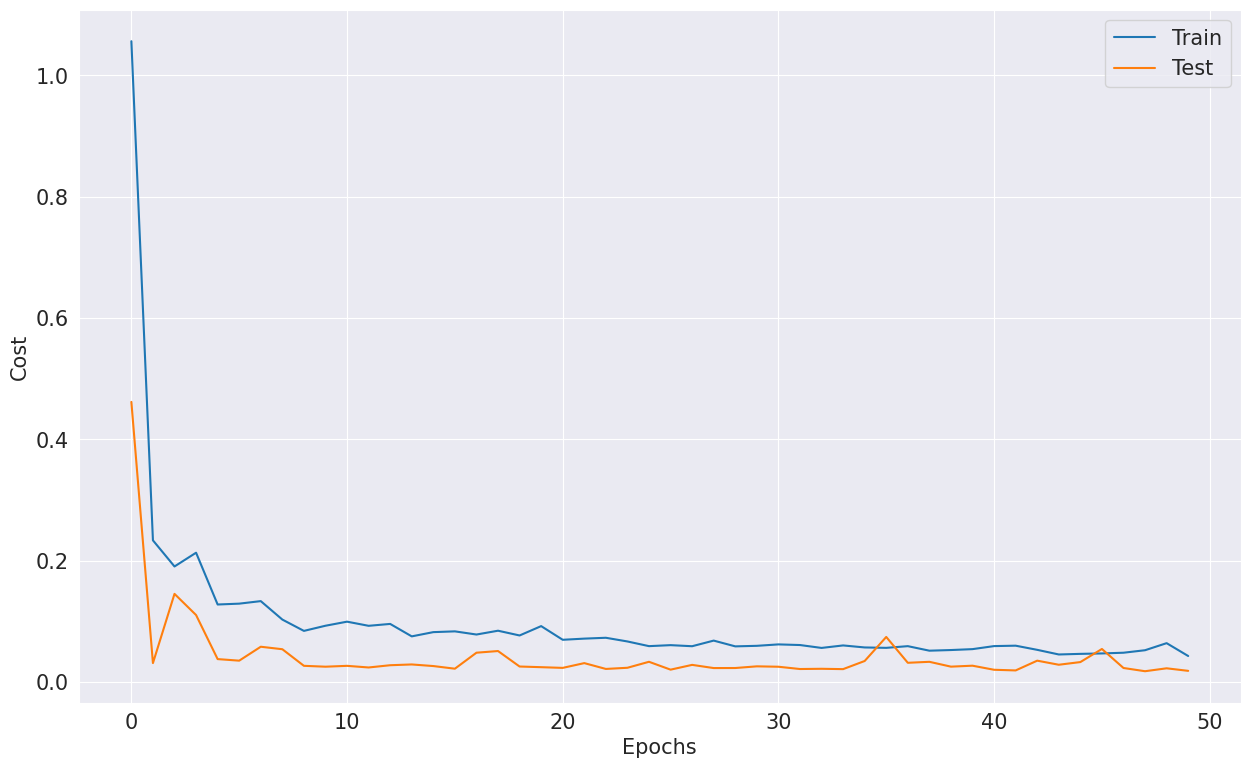

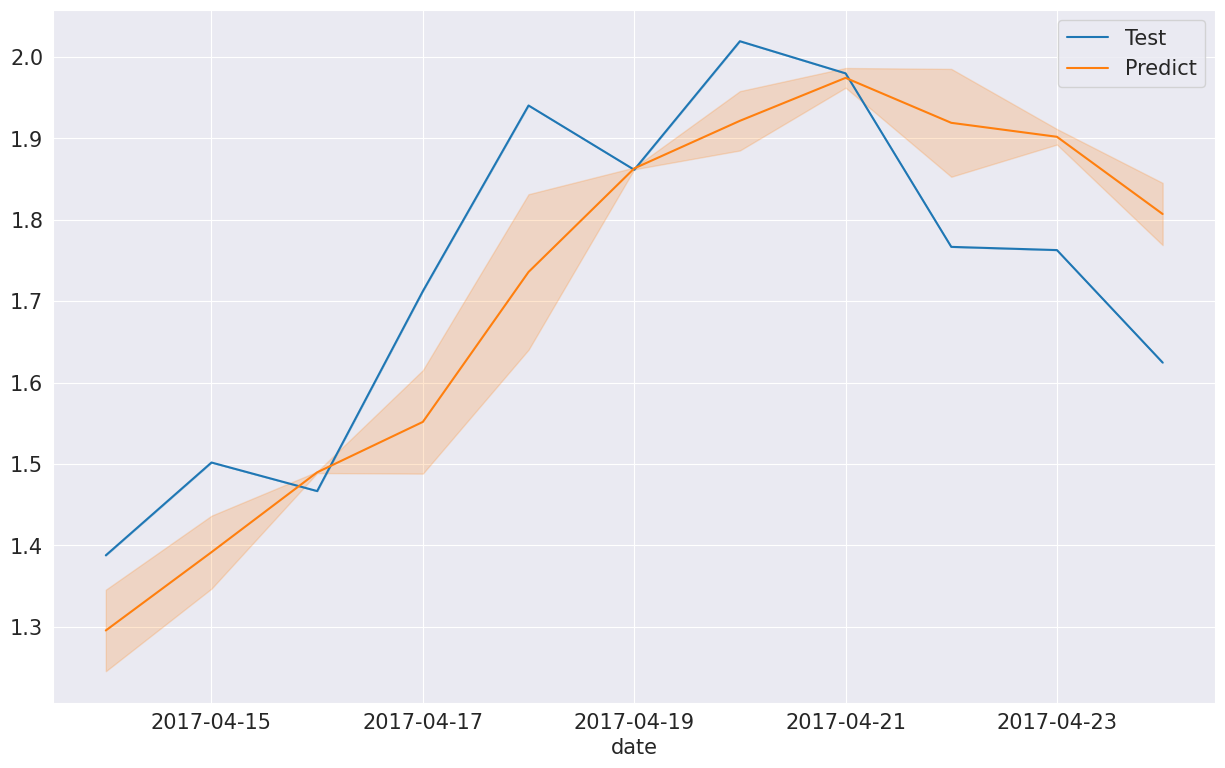

In [61]:
y_predict = model.predict(x_test)

print_loss(result)
print_test_x_prediction(y_test, y_predict, df['date'], len(y_train), window=window)